In [4]:
from pathlib import Path
from shapely.errors import ShapelyDeprecationWarning

import json
import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
import warnings
import matplotlib.patches as patches

from helper import root

warnings.filterwarnings(action='ignore', category=ShapelyDeprecationWarning)

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [6]:
competition = "ref_fusion_competition_south_africa"
labels_258_path = root / f"{competition}_train_labels/{competition}_train_labels_34S_19E_258N/labels.geojson"
labels_258 = gpd.read_file(labels_258_path)

labels_259_path = root / f"{competition}_train_labels/{competition}_train_labels_34S_19E_259N/labels.geojson"
labels_259 = gpd.read_file(labels_259_path)

labels = pd.concat([labels_258, labels_259], ignore_index=True)

labels_test_path = root / f"{competition}_test_labels/{competition}_test_labels_34S_20E_259N/labels.geojson"
labels_test = gpd.read_file(labels_test_path)

In [7]:
all_labels = pd.concat([labels, labels_test])
x_min, y_min, x_max, y_max = all_labels.total_bounds

In [47]:
validation_split = 0.2
lon = labels.geometry.centroid.apply(lambda p: p.x)
train_indices = (lon[lon <= lon.quantile(1 - validation_split)]).index.to_list()
val_indices = (lon[lon > lon.quantile(1 - validation_split)]).index.to_list()
np.random.RandomState(0).shuffle(train_indices)
np.random.RandomState(0).shuffle(val_indices)

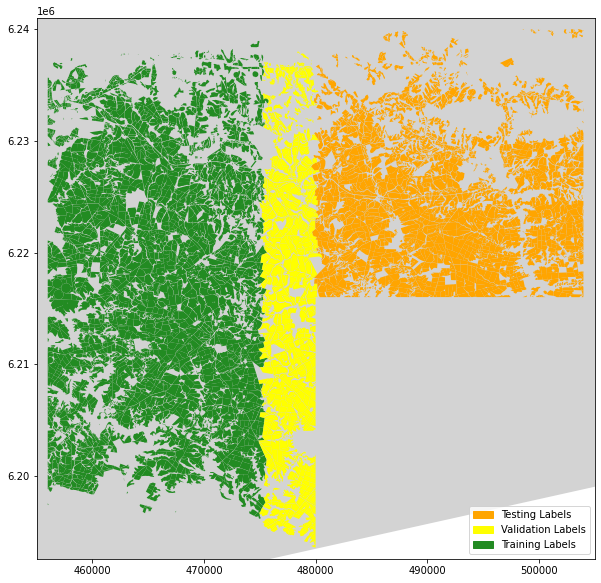

In [48]:
ax = world[world["name"] == "South Africa"].to_crs("EPSG:32734").plot(figsize=(10,10), color="lightgray")
padding = 1000
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)
labels.iloc[train_indices].plot(ax=ax, color="forestgreen")
labels.iloc[val_indices].plot(ax=ax, color="yellow")
labels_test.plot(ax=ax, color="orange")
    
ax.legend(loc='lower right', handles=[
    patches.Patch(color='orange', label='Testing Labels'),
    patches.Patch(color='yellow', label='Validation Labels'),
    patches.Patch(color='forestgreen', label='Training Labels')
])

In [14]:
name = "s2_lstm_epoch_49"
p = Path(f"../submissions/{name}/34S-20E-259N-2017-submission-{name}.json")
assert p.exists(), f"{p} does not exist"
with p.open("rb") as f:
    data =  json.load(f)

<AxesSubplot:>

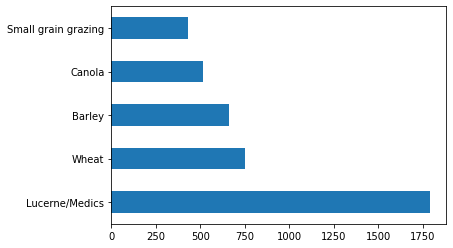

In [17]:
df = pd.concat([labels_258, labels_259])
df["crop_name"].value_counts().plot(kind="barh")

# Does field size help predict crop type?

In [22]:
df.head()

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
0,80172,86608.783197,2165.333019,4,Lucerne/Medics,"MULTIPOLYGON (((456686.552 6215911.790, 456700..."
1,80217,129169.262104,1478.177480,2,Barley,"MULTIPOLYGON (((459030.598 6215734.313, 458988..."
2,80225,231420.387803,2007.104974,4,Lucerne/Medics,"MULTIPOLYGON (((458356.570 6216251.177, 458489..."
3,80228,100817.991529,1468.847742,4,Lucerne/Medics,"MULTIPOLYGON (((459818.661 6216018.564, 459809..."
4,80229,375263.554123,2693.791755,3,Canola,"MULTIPOLYGON (((459945.661 6215862.459, 460150..."


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [53]:
split = int(len(df)*0.8)
X = df["SHAPE_AREA"].to_numpy().reshape(-1,1)
y = df["crop_id"]
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

In [54]:
clf = SVC()#RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

SVC()

In [55]:
y_pred = clf.predict(X_val)

In [56]:
accuracy_score(y_val, y_pred)

0.5054151624548736

/cmlscratch/izvonkov/tum-planet-radearth-ai4food-challenge/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


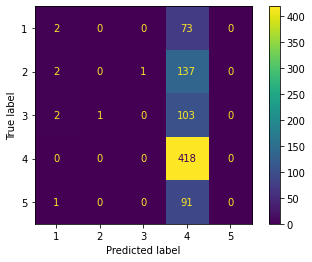

In [57]:
plot_confusion_matrix(clf, X_val, y_val)

# Error Analysis
- Identify failure modes / categorize each error
- Which classes are mislabeled most
- Which region are classes mislabeled by

Mean NDVI / NIR for each crop type
Read difference between crop types
Read what other the deciding factors for farmers to planet these different crop types